In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import lightgbm as lgb

sns.set(style="whitegrid")



In [2]:
# Loading preprocessed dataset

X_train = np.load("X_train.npy")
X_test  = np.load("X_test.npy")
y_train = np.load("y_train.npy")
y_test  = np.load("y_test.npy")

In [3]:
#  FEATURE IMPORTANCE (Random Forest for initial insight)

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

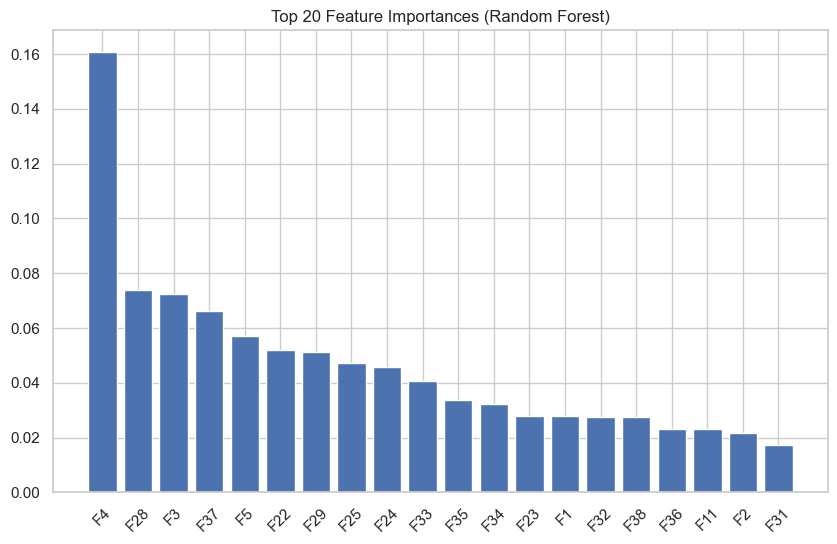

In [4]:
# Top 20 features
top_n = 20
plt.figure(figsize=(10,6))
plt.title("Top 20 Feature Importances (Random Forest)")
plt.bar(range(top_n), importances[indices[:top_n]], align="center")
plt.xticks(range(top_n), [f"F{i}" for i in indices[:top_n]], rotation=45)
plt.show()



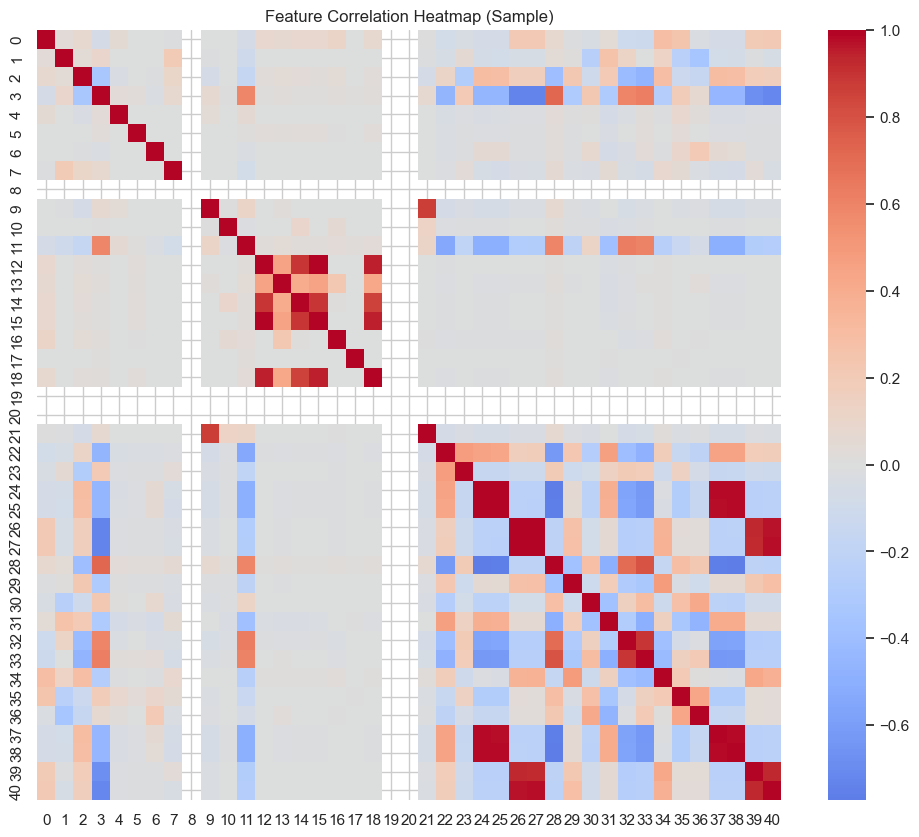

In [5]:

# CORRELATION ANALYSIS


sample_X = pd.DataFrame(X_train[:5000])
corr = sample_X.corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Feature Correlation Heatmap (Sample)")
plt.show()



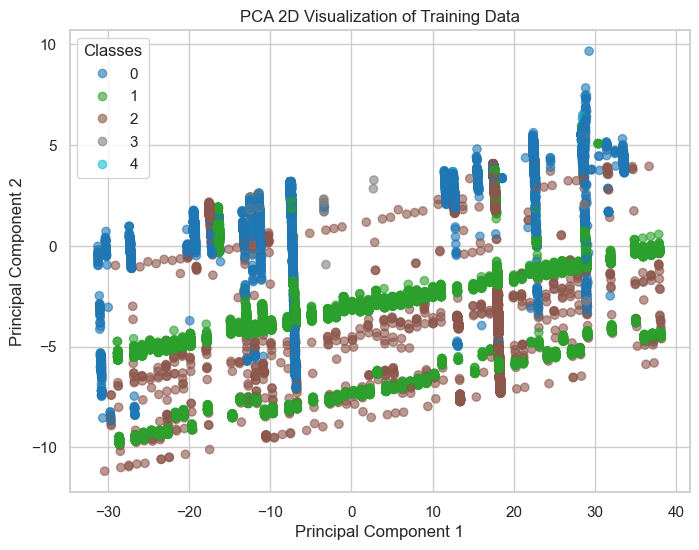

In [6]:
# PCA VISUALIZATION

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=pd.factorize(y_train)[0], cmap='tab10', alpha=0.6)
plt.title("PCA 2D Visualization of Training Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(*scatter.legend_elements(), title="Classes")
plt.show()

In [7]:
#  LIGHTGBM TRAINING (MULTICLASS)

train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

params = {
    "objective": "multiclass",
    "num_class": len(np.unique(y_train)),
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "metric": "multi_logloss",
    "num_leaves": 70,
    "max_depth": -1,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
}

lgb_model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, valid_data],
    num_boost_round=300,
    callbacks=[lgb.early_stopping(stopping_rounds=40), lgb.log_evaluation(50)]
)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3151
[LightGBM] [Info] Number of data points in the train set: 100778, number of used features: 38
[LightGBM] [Info] Start training from score -1.008374
[LightGBM] [Info] Start training from score -2.380221
[LightGBM] [Info] Start training from score -4.841076
[LightGBM] [Info] Start training from score -8.630304
[LightGBM] [Info] Start training from score -0.626272
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 40 rounds
[50]	training's multi_logloss: 0.0154534	valid_1's multi_logloss: 0.0284895
[100]	training's multi_logloss: 0.00215598	valid_1's multi_logloss: 0.0201784
[LightGBM] 

In [8]:
# PREDICTIONS & EVALUATION
y_pred_proba = lgb_model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


Test Accuracy: 0.9982536217503473

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9192
           1       1.00      1.00      1.00      2331
           2       0.99      0.95      0.97       199
           3       0.00      0.00      0.00         4
           4       1.00      1.00      1.00     13469

    accuracy                           1.00     25195
   macro avg       0.80      0.79      0.79     25195
weighted avg       1.00      1.00      1.00     25195



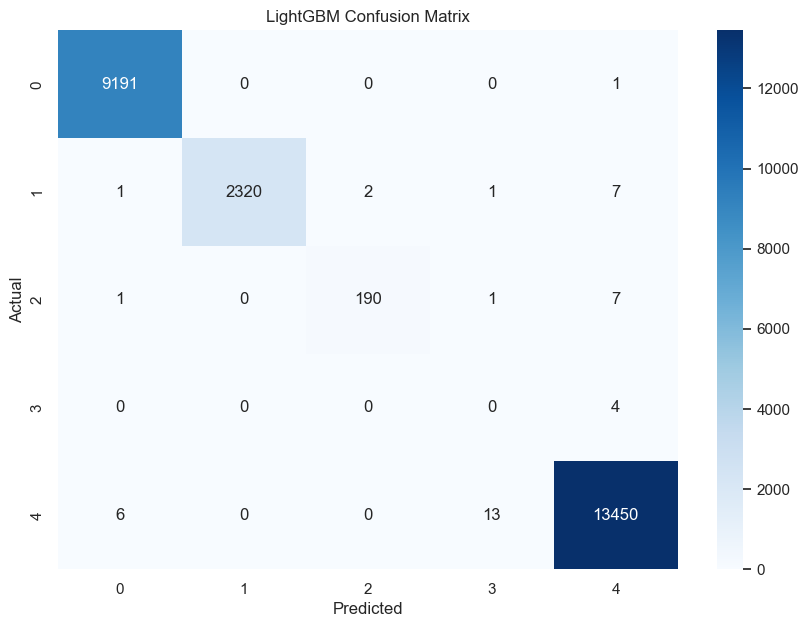

In [9]:

# CONFUSION MATRIX

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("LightGBM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


<Figure size 1000x600 with 0 Axes>

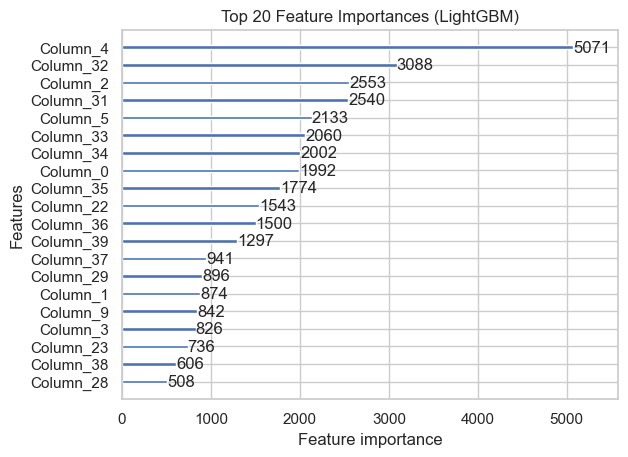

In [10]:

# FEATURE IMPORTANCE (LightGBM)

plt.figure(figsize=(10,6))
lgb.plot_importance(lgb_model, max_num_features=20)
plt.title("Top 20 Feature Importances (LightGBM)")
plt.show()


In [11]:

#SAVE MODEL & PREDICTIONS

lgb_model.save_model("lgb_model.txt")

results = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred,
    "Max_Prob": np.max(y_pred_proba, axis=1)
})
results.to_csv("lightgbm_predictions.csv", index=False)
print("Model and predictions saved successfully!")


Model and predictions saved successfully!


In [14]:
# REAL-TIME INTRUSION SIMULATION

def simulate_realtime_detection(sample_index):
    sample = X_test[sample_index]
    prob = lgb_model.predict(sample.reshape(1, -1))[0]
    pred = np.argmax(prob)
    print(f"\nIncoming Packet Index: {sample_index}")
    print("Predicted Class:", pred)
    print("Confidence:", np.max(prob))
    if pred != 0:
        print("ALERT: Intrusion Detected!")
    else:
        print(" Normal Traffic")

In [18]:
# Example simulation
simulate_realtime_detection(500) # type: ignore


Incoming Packet Index: 500
Predicted Class: 0
Confidence: 0.9998536795691219
 Normal Traffic
